In [1]:
import os
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import re
import subprocess
import numpy as np
import math

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../src')

In [2]:
import random
import string
from sklearn.metrics import recall_score, confusion_matrix
from tensorboardX import SummaryWriter

from data.data_sample import DataSample

def define_seed(seed=12):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def read_samples(data_root, labels_path, wavs_path, logging=False):
    datasets = ['train', 'devel', 'test']
    all_labels = pd.read_csv(os.path.join(data_root, labels_path))
    
    all_samples = {}
    for dataset in datasets:
        
        labels_df = all_labels[all_labels['file_name'].str.startswith(dataset)].values
        
        samples = []
        for file_info in labels_df:
            fp = os.path.join(data_root, wavs_path, file_info[0])
            sample = DataSample(wav_path=fp,
                                file_name=file_info[0],
                                file_size=os.path.getsize(fp),
                                label=file_info[1])
    
            samples.append(sample)
        
        all_samples[dataset] = samples
    
    if logging:
        print('Count of samples: {0}'.format(sum([len(v) for k, v in all_samples.items()])))
        print(all_samples['train'][0])
    
    return all_samples

def display_transforms(loader, batch_idx, std, mean, idx_to_classes, predicts=None):
    assert batch_idx < len(loader) and batch_idx >= 0
    batch_size = loader.batch_size
    preds = None
    inputs = None
    labels = None
    paths = None
    
    loader_iter = iter(loader)
    for i in range(batch_idx + 1):
        if predicts is not None:
            inputs, labels, paths = next(loader_iter)
            preds = predicts[i * batch_size:(i + 1) * batch_size]
        else:
            inputs, preds = next(loader_iter)
    
        fig, axes = plt.subplots(ncols=4, nrows=4, constrained_layout=False, figsize=(15, 15))
        axes = axes.flatten()
        for img, label, ax in zip(inputs, preds, axes):
            image = img.permute(1, 2, 0).numpy()
            image = std * image + mean
            ax.autoscale(enable=True)
            ax.imshow(image.clip(0, 1))
            if predicts is not None:
                ax.title.set_text(str(label))
            elif idx_to_classes is not None:
                ax.title.set_text(idx_to_classes[np.asscalar(label.numpy())])
                
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', color_map=plt.cm.Blues, fig_path=None):
        """
        This function prints and plots the confusion matrix,
        Normalization can be applied by setting `normalize=True`
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

            # Compute confusion matrix
        # Only use the labels that appear in the data
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        np.set_printoptions(precision=3)
        print(cm)
        np.set_printoptions(precision=6)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(cm, interpolation='nearest', cmap=color_map)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

#         ax.set_xticks(np.arange(cm.shape[1] + 1)-.5)
#         ax.set_yticks(np.arange(cm.shape[0] + 1)-.5)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        fig.tight_layout()
        if fig_path:
            plt.savefig(fig_path)
        else:
            plt.show(block=False)
            
def get_best_model(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

def get_model_by_epoch(path, epoch):
    files = os.listdir(path)
    paths = [basename for basename in files if basename.startswith('epoch_{0}'.format(epoch)) and basename.endswith('.pth')]
    return os.path.join(path, paths[0])
            
def train_model(model, loss, optimizer, scheduler, num_epochs, 
                device, train_dataloader, valid_dataloader, experiment_name, log_iter=None):
    max_recall = 0.
    max_epoch = 0
    
    exp_folder = '{0}_{1}'.format(features, experiment_name)
    
    os.makedirs(os.path.join(log_root, exp_folder), exist_ok=True)
    save_path = os.path.join(log_root, exp_folder)

    tb_save_path = os.path.join(tb_log_root, exp_folder)
    
    summary = {
        'train': SummaryWriter('{0}_train'.format(tb_save_path)),
        'valid': SummaryWriter('{0}_valid'.format(tb_save_path))
    }
    
    for epoch in range(num_epochs):        
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            targets = []
            predicts = []
            
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            epoch_recall = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # forward and backward
                preds = None
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss_value.item()
                
                targets.extend(labels.cpu().numpy())
                predicts.extend(preds.cpu().detach().numpy())
                

            epoch_loss = running_loss / len(dataloader)
            
            targets, predicts = np.asarray(targets), np.argmax(np.asarray(predicts), axis=1)
            epoch_recall = recall_score(targets, 
                                        predicts,
                                        average='macro')
            
            summary[phase].add_scalar('recall', epoch_recall, global_step=epoch)
            summary[phase].add_scalar('loss', epoch_loss, global_step=epoch)
            print('{} Loss: {:.4f} Recall: {:.4f}'.format(phase, epoch_loss, epoch_recall), flush=True)
            
            if (((phase == 'valid') and (epoch_recall > max_recall)) or 
                ((phase == 'valid') and (log_iter is not None) and (epoch in log_iter))):
                
                if epoch_recall > max_recall:
                    max_recall = epoch_recall
                    max_epoch = epoch
                
                cm = confusion_matrix(targets, predicts, [0, 1])
                
                res_name = 'epoch_{0}_{1}'.format(epoch, epoch_recall)

                plot_confusion_matrix(cm=cm, 
                                      classes=class_names, 
                                      normalize=True, 
                                      title='{}.png'.format(res_name),
                                      fig_path=os.path.join(save_path, '{}.png'.format(res_name)))                
                model.cpu()
                torch.save({
                    'epoch': epoch,
                    'model': model,
                    'model_state_dict': model.state_dict(),
                    'optimizer': optimizer,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler,
                    'loss_function': loss},
                    os.path.join(save_path, '{}.pth'.format(res_name)))
                
                model.to(device)

    print('Epoch: {}, Max Recall: {:.4f}'.format(max_epoch, max_recall), flush=True)
    
    for phase in ['train', 'valid']:
        summary[phase].close()
    
    return model, max_epoch, max_recall

In [3]:
import warnings
warnings.filterwarnings('ignore')

import shutil 
import random
import torch

from tqdm import tqdm

data_root = '/media/maxim/SStorage/ComParE2020_Mask/'
features_root = 'features/'
wavs_path = 'wav/'
labels_path = 'lab/labels.csv'
log_root = '../logs/'
tb_log_root = '../logs/tb/'

features = 'mel_64'

print(os.listdir(os.path.join(data_root, features_root, features)))

train_dir = os.path.join(data_root, features_root, features, 'train')
valid_dir = os.path.join(data_root, features_root, features, 'devel')

class_names = ['clear', 'mask']

define_seed(12)

['devel', 'test', 'train']


In [4]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transforms = [
                    transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean, std)]),
]

valid_transforms = train_transforms.copy()
valid_transforms[0] = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(), 
                        transforms.Normalize(mean, std)])

train_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(train_dir, transformation) for transformation in train_transforms])

valid_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(valid_dir, transformation) for transformation in valid_transforms])

datasets = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])

labels = [sample[1] for sample in datasets]
train_labels = [sample[1] for sample in train_dataset]
valid_labels = [sample[1] for sample in valid_dataset]

In [5]:
import copy
import torchvision.models as models

class MaskNet(torch.nn.Module):
    def __init__(self, is_vgg=False, requires_grad=False):
        super(MaskNet, self).__init__()
        
        self.pretrained = None
        self.in_feat = 0
        if is_vgg:
            self.pretrained = models.vgg16(pretrained=True)
            self.in_feat = self.pretrained.classifier[0].in_features
        else:
            self.pretrained = models.resnet18(pretrained=True)
            self.in_feat = self.pretrained.fc.in_features
            
        for param in self.pretrained.parameters():
            param.requires_grad = requires_grad
        
        model_ext = torch.nn.Sequential(
            torch.nn.Linear(self.in_feat, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(.6),
            torch.nn.Linear(256, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(.6),
        )
        
        if is_vgg:
            self.pretrained.classifier = model_ext
        else:
            self.pretrained.fc = model_ext
        
        self.last_fc = torch.nn.Linear(16, 2)
    
    def forward(self, X):
        X = self.pretrained(X)
        
        X = self.last_fc(X)
        
        return X

In [6]:
from sklearn.model_selection import StratifiedKFold

train_indexes = np.arange(0, len(train_labels))
valid_indexes = np.arange(len(train_labels), len(valid_labels) + len(train_labels))

splits = []

# valid
valid_skf = StratifiedKFold(n_splits=2, random_state=12, shuffle=True)
valid_splits = valid_skf.split(np.zeros(len(valid_labels)), np.asarray(valid_labels))
for i, (t, v) in enumerate(valid_splits):
    v_t = valid_indexes[t]
    v_v = valid_indexes[v]
    splits.append((np.hstack((train_indexes, v_t)), v_v))
    
# train
train_skf = StratifiedKFold(n_splits=2, random_state=12, shuffle=True)
train_splits = train_skf.split(np.zeros(len(train_labels)), np.asarray(train_labels))
for i, (t, v) in enumerate(train_splits):
    t_t = train_indexes[t]
    t_v = train_indexes[v]
    splits.append((np.hstack((t_t, valid_indexes)), t_v))

In [ ]:
from sklearn.model_selection import StratifiedKFold

batch_size = 16

for i, (train_indexes, valid_indexes) in enumerate(splits):
    train_subset = torch.utils.data.Subset(datasets, train_indexes)
    valid_subset = torch.utils.data.Subset(datasets, valid_indexes)
    train_dataloader = torch.utils.data.DataLoader(train_subset, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=batch_size if batch_size < 9 else 8)
    valid_dataloader = torch.utils.data.DataLoader(valid_subset, 
                                                   batch_size=batch_size, 
                                                   shuffle=False, 
                                                   num_workers=batch_size if batch_size < 9 else 8)
    
    define_seed(12)
    model = MaskNet(is_vgg=False, requires_grad=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01)
    
       
    model, max_epoch, max_recall = train_model(model, loss, optimizer, scheduler, num_epochs=100,
                                               device=device, 
                                               train_dataloader=train_dataloader, 
                                               valid_dataloader=valid_dataloader, 
                                               experiment_name='resnet18_grad_100_4newFoldShuffle_{0}'.format(i),
                                               log_iter=[68, 98])
    
    print('Fold {0}: epoch: {1}, maximum recall: {2}\n'.format(i, max_epoch, max_recall))

(14647, 2)
(14647,)
Recall = 0.9998120536273649
Normalized confusion matrix
[[1.000e+00 0.000e+00]
 [3.759e-04 9.996e-01]]


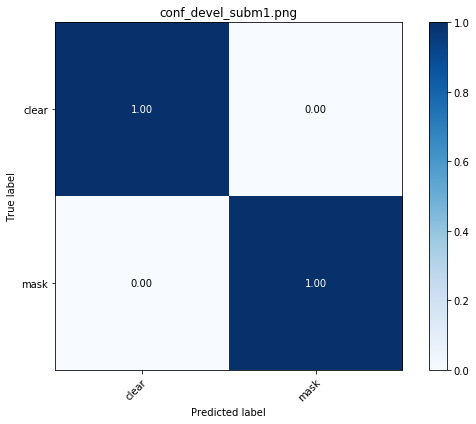

In [7]:
from sklearn.metrics import recall_score, confusion_matrix

# Devel set
valid_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(valid_dir, transformation) for transformation in valid_transforms])

validation_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, 
                                                    shuffle=False, num_workers=6)

all_valid_predictions = []
valid_labels = []
for i in range(0, 4):
    valid_preds = []
    valid_labels = []
    
    dictionary_path = get_model_by_epoch(os.path.join(log_root, 'mel_64_resnet18_grad_100_4newFoldShuffle_{0}'.format(i)), 68)
    checkpoint = torch.load(dictionary_path)
    
    model = MaskNet(is_vgg=False, requires_grad=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Iterate over data.
    for inputs, labels in validation_dataloader:
        valid_labels.append(labels.numpy())

        inputs = inputs.to(device)
        labels = labels.to(device)
        predicts = None
        
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        
        predicts = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
        valid_preds.append(predicts)
    
    all_valid_predictions.append(np.concatenate(valid_preds))

val_preds = np.mean(np.stack(all_valid_predictions), axis=0)
val_labels = np.concatenate(valid_labels)

print(val_preds.shape)
print(val_labels.shape)


recall = recall_score(val_labels, np.argmax(val_preds, axis=1), labels=[0, 1], average='macro')
print('Recall = {0}'.format(recall))

cm = confusion_matrix(val_labels, np.argmax(val_preds, axis=1), [0, 1])
plot_confusion_matrix(cm=cm, classes=['clear', 'mask'], normalize=True, 
                      title='conf_devel_subm1.png', fig_path='conf_devel_subm1.png')

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dir = os.path.join(data_root, features_root, features, 'test')
batch_size = 16
test_dataset = ImageFolderWithPaths(test_dir, valid_transforms[0])
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False, 
                                              num_workers=6)

test_img_paths = []
all_test_predictions = []

for i in range(0, 4):
    test_img_paths = []
    test_preds = []
    
    dictionary_path = get_model_by_epoch(os.path.join(log_root, 'mel_64_resnet18_grad_100_4newFoldShuffle_{0}'.format(i)), 68)
    checkpoint = torch.load(dictionary_path)
    
    model = MaskNet(is_vgg=False, requires_grad=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for inputs, labels, paths in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        predicts = None
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        
        predicts = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
    
        test_preds.append(predicts)
        test_img_paths.extend(paths)
    
    test_preds = np.concatenate(test_preds)
    all_test_predictions.append(test_preds)

test_preds = np.mean(np.stack(all_test_predictions), axis=0)

In [ ]:
pred_file_name = 'ComParE2020_Mask.{0}.test.IIAS_1.csv'.format(features)

prepare_filenames = lambda x: '{0}.wav'.format(os.path.splitext(os.path.basename(x))[0])
int_to_label = {v: k for k, v in train_dataset.datasets[0].class_to_idx.items()}
submission_df = pd.DataFrame.from_dict({'file_name': [prepare_filenames(filepath) for filepath in test_img_paths], 
                                        'prediction': [int_to_label[pred] for pred in np.argmax(test_preds, axis=1)]})
submission_df.to_csv(pred_file_name, index=False)

In [ ]:
# D=63.4 | T=70.8
test_top_1 = pd.read_csv('../src/applications/ComParE2020_Mask.DeepSpectrum_resnet50.test.baseline_1.csv')
# D=62.3 | T=67.8
test_top_2 = pd.read_csv('../src/applications/ComParE2020_Mask.ComParE.test.baseline_1.csv')

In [ ]:
test_top_1['predMatch?'] = np.where(test_top_1['prediction'] == submission_df['prediction'], 'True', 'False')
test_top_1['fnMatch?'] = np.where(test_top_1['file_name'] == submission_df['file_name'], 'True', 'False')

test_top_2['predMatch?'] = np.where(test_top_2['prediction'] == submission_df['prediction'], 'True', 'False')
test_top_2['fnMatch?'] = np.where(test_top_2['file_name'] == submission_df['file_name'], 'True', 'False')

In [ ]:
test_top_1.describe()

In [ ]:
test_top_2.describe()